# Proof of concept - online rhat

This proof of concept computes split rhat for multichain inference, for a single posterior using Nuts/Blackjax.

The model is a simple Gaussian linear regression. Rhat calcs are validated against Arviz.

In [23]:
import blackjax
import jax
import chex
import jax.numpy as jnp
import arviz as az
from tensorflow_probability.substrates import jax as tfp
from collections import namedtuple
import matplotlib.pyplot as plt
from typing import NamedTuple
from jax.tree_util import tree_map, tree_structure
import pandas as pd

tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

ADT for the welford algorithm that tracks mean, absolute mean deviation, and variance for each chain variable of interest. This type will end up being the leaf of a pytree structured like the parameter.

In [24]:
class WelfordState(NamedTuple):
    K: chex.Array  # central estimate of data
    Ex: chex.Array  # sum of deviations from K
    Eax: chex.Array  # sum of absolute deviations from K
    Ex2: chex.Array  # sum of squared deviations from K
    n: chex.Array  # number of data points


def welford_init(K: chex.Array) -> WelfordState:
  """Initialize new welford algorithm state.
  
  Args:
    K: estimated mean value of data. Same shape as data.
  """
  return WelfordState(K=K*1., Ex=K*0., Eax=K*0., Ex2=K*0., n=K*0)

def welford_add(x: chex.Array, state: WelfordState) -> WelfordState:
  return WelfordState(
    K=state.K,
    Ex=state.Ex + x - state.K,
    Eax=state.Eax + jnp.abs(x - state.K),
    Ex2=state.Ex2 + (x - state.K)**2,
    n=state.n + 1)

def welford_mean(state: WelfordState):
  return state.K + state.Ex / state.n

def welford_mad(state: WelfordState):
  return state.Eax / state.n

def welford_var(state: WelfordState):
  return (state.Ex2 - state.Ex**2 / state.n) / (state.n - 1)

In [25]:
class Theta(NamedTuple):
    beta: chex.Array
    sigsq: chex.Array

In [26]:
def split_rhat(means: chex.Array, vars: chex.Array, n: int) -> float:
    """Compute a single split Rhat from summary statistics of split chains.

    Args:
        means: means of split chains
        vars:  variances of split chains
        n:     number of draws per split chain (ie half draws in an original chain)
    """
    W = jnp.mean(vars, axis=0)
    m = len(means)  # number of split chains
    B = n*jnp.var(means, ddof=1, axis=0)
    varplus = (n-1)/n*W + B/n
    Rhat = jnp.sqrt(varplus/W)
    return Rhat

def split_rhat_welford(ws: WelfordState) -> float:
    """Compute split Rhat from Welford state of split chains.

    Args:
        ws: Welford state of split chains
    
    Returns:
        split Rhat: array of split Rhats
    """
    means = jax.vmap(welford_mean)(ws)
    vars = jax.vmap(welford_var)(ws)
    n = ws.n[0]
    return split_rhat(means, vars, n)

def folded_split_rhat_welford(ws: WelfordState) -> float:
    """Compute folded split Rhat from Welford state of split chains.

    Args:
        ws: Welford state of split chains
    
    Returns:
        folded split Rhat: array of folded split Rhats
    """
    mads = jax.vmap(welford_mad)(ws)
    vars = jax.vmap(welford_var)(ws)
    n = ws.n[0]
    return split_rhat(mads, vars, n)

def rhat(welford_tree):
    """Compute split Rhat and folded split Rhat from welford states of split chains.
    
    Args:
        welford_tree: pytree of Welford states for split chains
    
    Returns:
        split Rhat: pytree pytree of split Rhats
        folded split Rhat: pytree of folded split Rhats
    """
    # first two axes are (chain #, half #), which we combine to a single dimension
    com_chains = tree_map(lambda x: jnp.reshape(x, (-1, *x.shape[2:])), welford_tree)
    sr = tree_map(split_rhat_welford, com_chains, is_leaf=lambda x: isinstance(x, WelfordState))
    fsr = tree_map(folded_split_rhat_welford, com_chains, is_leaf=lambda x: isinstance(x, WelfordState))
    return sr, fsr

In [27]:
class ExtendedState(NamedTuple):
    state: blackjax.mcmc.hmc.HMCState  # current HMC state
    rng_key: chex.Array  # current random seed
    pred_ws: WelfordState  # accumulator for predictive
    param_ws: WelfordState  # accumulator for parameters
    divergences: chex.Array  # divergence counts (int array)

    def __repr__(self) -> str:
        rhats = [(n, rhat(v)) for n, v in zip(self.param_ws._fields, self.param_ws)]
        predrh, predsrh = rhat(self.pred_ws)
        status = [
            f'       Summary: {int(jnp.sum(self.pred_ws.n[0,:]))} draws * {self.state.position[0].shape[0]} chains',
        ]
        param = [f'{n: >9} Rhat: {v} ({desc})' for n, (rh, frh) in rhats for v, desc in [(rh, 'regular'), (frh, 'tail')]]
        lines = status + param + [
            f"    pred. Rhat: {predrh:.4f}  tail: {predsrh:.4f}",
            f"   divergences: {int(jnp.sum(self.divergences))}"
        ]
        return '\n'.join(lines)


## Model definition

In [28]:
y_key, X_key = jax.random.split(jax.random.PRNGKey(0))
N = 100
beta0 = jnp.array([1.0, 2.0, 3.0, 4.0])
p = len(beta0)
sigsq0 = jnp.array(2.0)
X = tfd.Normal(loc=0, scale=1).sample(sample_shape=(N, p), seed=X_key)
y = X@beta0 + tfd.Normal(loc=0, scale=jnp.sqrt(sigsq0)).sample(sample_shape=(N,), seed=y_key)
# y = y.at[23].set(400.0)  # outlier

In [29]:
# use exp to transform sigsq to unconstrained space
sigsq_t = tfb.Exp()

beta_prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=jnp.ones(p))
sigsq_prior = tfd.Gamma(concentration=1.0, rate=1.0)

def logprob_fn(theta: Theta):
  sigsq = sigsq_t.forward(theta.sigsq)
  sigsq_ldj = sigsq_t.forward_log_det_jacobian(theta.sigsq)
  lprior = beta_prior.log_prob(theta.beta) + sigsq_prior.log_prob(theta.sigsq)
  lhood = tfd.Normal(loc=X@theta.beta, scale=jnp.sqrt(sigsq)).log_prob(y).sum()
  return lprior + lhood

# predictive density log p(y|theta)
def log_p(theta):
    e = X @ theta.beta - y
    return -0.5 * (
        jnp.log(2 * jnp.pi)
        + jnp.log(theta.sigsq)
        + jnp.dot(e, e)/theta.sigsq
    )


In [30]:
num_samples = 100
warmup_iter = 500
num_chains = 3
seed = 123
warmup_key, sampling_key, init_key, subs_key = jax.random.split(jax.random.PRNGKey(seed), 4)

# random initialization in the constrained parameter space
def make_initial_pos(key, pid):
  k1, k2 = jax.random.split(key)
  theta = Theta(
    beta=jax.random.normal(key=k1, shape=(p,)),
    sigsq=jax.random.normal(key=k2))
  return theta

## Inference

In [31]:
%%time

warmup = blackjax.window_adaptation(blackjax.nuts, logprob_fn, num_steps=warmup_iter, progress_bar=True)
final_warmup_state, kernel, info = warmup.run(warmup_key, make_initial_pos(init_key, 0))

Running window adaptation



CPU times: user 2.74 s, sys: 17.8 ms, total: 2.76 s
Wall time: 2.73 s


In [32]:
# stack arrays in pytrees
def tree_stack(trees):
    return tree_map(lambda *xs: jnp.stack(xs, axis=0), *trees)

# stack arrays in pytrees
def tree_concat(trees):
    return tree_map(lambda *xs: jnp.concatenate(xs, axis=0), *trees)

In [33]:
# sample initial positions from second half of warmup trajectory
idxs = jax.random.choice(subs_key, a=jnp.arange(warmup_iter//2, warmup_iter), shape=(num_chains,))
initial_positions = Theta(
    beta = info[0].position.beta[idxs,],
    sigsq = info[0].position.sigsq[idxs]
)
centers = tree_map(lambda x: jnp.median(x[x.shape[0]//2:,...], axis=0), info[0].position)
initial_states = jax.vmap(lambda p: blackjax.nuts.init(p, logprob_fn))(initial_positions)

In [34]:
tree_map(lambda x: x.shape, centers)

Theta(beta=(4,), sigsq=())

In [35]:
# sense check logprob_fn
[logprob_fn(final_warmup_state.position), jax.vmap(logprob_fn)(initial_positions)]

[Array(-193.98865, dtype=float32),
 Array([-193.38307, -191.24486, -195.57587], dtype=float32)]

Seems pretty safe to sample from second half of warmup trace. The dotted lines show the "center" variables used for the midpoint of folded Rhat.

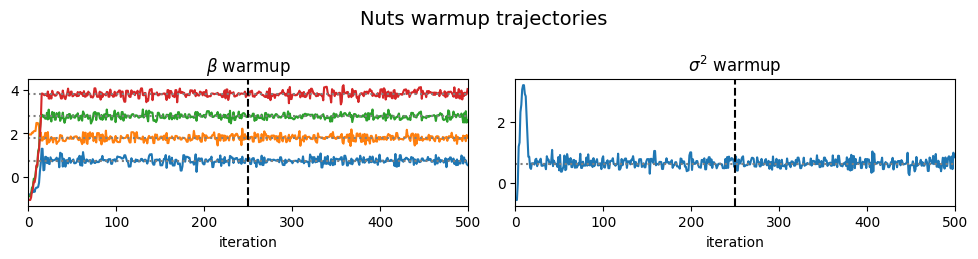

In [36]:
fig, axes = plt.subplots(1,2, figsize=(10,2.6))
for i, (ax, n) in enumerate(zip(axes, ['beta', 'sigma^2'])):
    ax.set_xlabel('iteration')
    ax.set_title(f'$\\{n}$ warmup')
    ax.plot(info[0].position[i])
    ax.axvline(warmup_iter//2, color='k', linestyle='--')
    ax.set_xlim(0, info[0].position.beta.shape[0])
    if centers[i].ndim > 0:
        for c in centers[i]:
            ax.axhline(c, color='gray', linestyle=':')
    else:
        ax.axhline(centers[i], color='gray', linestyle=':')
fig.suptitle('Nuts warmup trajectories', fontsize=14)
fig.tight_layout()

Named tuple for holding MCMC results, split into 2 half-chains

In [37]:
# single chain inference loop we will run in parallel using vmap
def inference_loop(rng_key, kernel, initial_state, num_samples, log_p, centers):
    def one_mcmc_step(ext_state, idx):
        i_key, carry_key = jax.random.split(ext_state.rng_key)
        chain_state, chain_info = kernel(i_key, ext_state.state)
        elpd_contrib = log_p(chain_state.position)
        div_count = ext_state.divergences + chain_info.is_divergent.astype(jnp.float32)
        carry_pred_ws = welford_add(elpd_contrib, ext_state.pred_ws)
        carry_param_ws = tree_map(welford_add, chain_state.position, ext_state.param_ws)
        carry_state = ExtendedState(chain_state, carry_key, carry_pred_ws, carry_param_ws, div_count)
        return carry_state, chain_state  # we'll eventually drop chain state and return None instead
    # first half of chain
    initial_state_1h = ExtendedState(
        initial_state,
        rng_key,
        pred_ws=welford_init(log_p(centers)),
        param_ws=tree_map(welford_init, centers),
        divergences=0)
    #carry_state_1h = jax.lax.fori_loop(0, num_samples//2, one_step, initial_state_1h)
    carry_state_1h, states_1h = jax.lax.scan(one_mcmc_step, initial_state_1h, jnp.arange(0, num_samples//2))
    # second half of chain - continue at same point but accumulate into new welford states
    initial_state_2h = ExtendedState(
        carry_state_1h.state,
        carry_state_1h.rng_key,
        pred_ws=welford_init(log_p(centers)),
        param_ws=tree_map(welford_init, centers),
        divergences=0)
    #carry_state_2h = jax.lax.fori_loop(0, num_samples//2, one_step, carry_state_1h)
    carry_state_2h, states_2h = jax.lax.scan(one_mcmc_step, initial_state_2h, jnp.arange(num_samples//2, num_samples))
    return tree_stack((carry_state_1h, carry_state_2h,)), tree_concat((states_1h, states_2h,))

In [38]:
def to_arviz(theta):
    theta_dict = dict(zip(theta.position._fields, theta.position))
    return az.convert_to_inference_data(theta_dict)

In [47]:
%%time

sampling_keys = jax.random.split(sampling_key, num_chains)

state, trace = jax.vmap(inference_loop, in_axes=(0, None, 0, None, None, None))(sampling_keys, kernel, initial_states, num_samples, log_p, centers)
state

CPU times: user 6.53 s, sys: 45.3 ms, total: 6.58 s
Wall time: 6.55 s


       Summary: 100 draws * 3 chains
     beta Rhat: [1.0000408 0.9975882 1.0194485 1.0033971] (regular)
     beta Rhat: [0.9956104  0.99485505 0.99697775 0.9959548 ] (tail)
    sigsq Rhat: 0.9945297241210938 (regular)
    sigsq Rhat: 0.9930577278137207 (tail)
    pred. Rhat: 0.9982  tail: 0.9961
   divergences: 0

## Results

In [40]:
trace_az = to_arviz(trace)
az.summary(trace_az)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.767,0.138,0.509,1.019,0.007,0.005,418.0,259.0,1.01
beta[1],1.779,0.144,1.490,2.040,0.007,0.005,421.0,257.0,1.00
beta[2],2.792,0.121,2.592,3.025,0.008,0.006,242.0,196.0,1.02
beta[3],3.798,0.130,3.532,4.022,0.006,0.004,450.0,236.0,1.00
sigsq,0.629,0.158,0.379,0.944,0.008,0.006,388.0,176.0,1.00


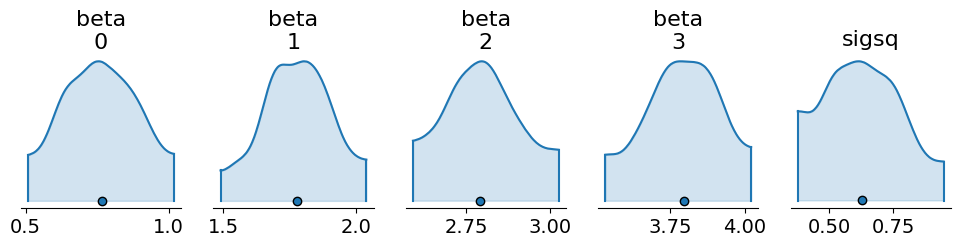

In [41]:
az.plot_density(trace_az, var_names=['beta', 'sigsq'], figsize=(12,2), shade=0.2, grid=(1,5))
fig.tight_layout()

Compute split Rhat for the parameter

In [42]:
s_rhats, fs_rhats = rhat(state.param_ws)
print("Regular split rhats")
print(s_rhats)
print("Folded split rhats")
print(fs_rhats)

Regular split rhats
Theta(beta=Array([1.0000408, 0.9975882, 1.0194485, 1.0033971], dtype=float32), sigsq=Array(0.9945297, dtype=float32))
Folded split rhats
Theta(beta=Array([0.9956104 , 0.99485505, 0.99697775, 0.9959548 ], dtype=float32), sigsq=Array(0.9930577, dtype=float32))


And compare it with Arviz

In [43]:
rhats_df_az = az.rhat(trace_az, method='split').to_dataframe()
# verify they match
assert jnp.linalg.norm(rhats_df_az.beta.to_numpy() - s_rhats.beta) < 1e-6
assert jnp.abs(rhats_df_az.sigsq.to_numpy()[0] - s_rhats.sigsq) < 1e-6
print("Rhats match")
rhats_df_az

Rhats match


,beta,sigsq
beta_dim_0,,
0,1.000041,0.99453
1,0.997588,0.99453
2,1.019448,0.99453
3,1.003397,0.99453


Now compute Rhat for predictive quantity (in this case log density)

In [44]:
prh, pfrh = rhat(state.pred_ws)
print(f'Predictive regular rhat = {prh}, predictive folded rhat = {pfrh}')

Predictive regular rhat = 0.9981593489646912, predictive folded rhat = 0.9961414933204651
